#### Learning rate schedules for stochastic gradient descent are known to improve the convergence of deep learning models. In this exercise we experiment with two decay strategies and compare their performance against a fixed learning rate schedule. The experiments are based on the deep learning model that learns to distinguish between cats and dogs.

#### First, we run the algorithm with the fixed learning rate set to 0.05. After 100 epochs it gives the test set accuracy of 0.7005.

In [26]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
import numpy as np

# fix the seed for reproducibility
from numpy.random import seed
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

batch_size = 64
num_classes = 2
epochs = 100

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

learning_rate = 0.05
sgd = optimizers.SGD(lr=learning_rate, momentum=0.8, decay=0.0, nesterov=False)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

print("SGD with fixed learning rate lr=%.2f" % learning_rate)
history1 = model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=0,
      validation_data=(x_test, y_test))

print ('Final accuracy on test set: %f' % float(history1.history['val_acc'][-1]))

x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
SGD with fixed learning rate lr=0.05
Final accuracy on test set: 0.700500


#### One way of annealing the learning rate is to make it adaptive to the changes in accuracy on the test set. The strategy we propose is to decrease the learning rate in proportion to the increase in accuracy at each epoch. The parameter eta is used to control this proportion. Running this schedule for 100 epochs with eta = 3 results in the final test set accuracy of 0.7105.

In [28]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import numpy as np

# fix the seed for reproducibility
from numpy.random import seed
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

acc_increase = 0.0
class AccHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.accuracies = []
    def on_epoch_end(self, batch, logs={}):
        global acc_increase
        previous_acc = 0.5
        current_acc = logs.get('val_acc')
        if len(self.accuracies) > 0:
            previous_acc = self.accuracies[-1]
        acc_delta = current_acc - previous_acc
        acc_increase = max(acc_delta / previous_acc, 0.0)
        self.accuracies.append(current_acc)

previous_lr = 0.05 #initial learning rate
lr_accuracy_based_decay = []
def accuracy_based_decay(t):
    global previous_lr
    eta = 3.0 #multiplier
    lr = previous_lr - previous_lr * acc_increase * eta
    lr_accuracy_based_decay.append(lr)
    previous_lr = lr
    return lr

batch_size = 64
num_classes = 2
epochs = 100

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

sgd = optimizers.SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

history=AccHistory()
lr = LearningRateScheduler(accuracy_based_decay)
callbacks_list = [history, lr]
print("SGD with accuracy-based decay")
history2 = model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=callbacks_list,
      verbose=0,
      validation_data=(x_test, y_test))

print ('Final accuracy on test set: %f' % float(history2.history['val_acc'][-1]))

x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
SGD with accuracy-based decay
Final accuracy on test set: 0.710500


#### One straightforward learning rate schedule is the exponential decay, controlled with the paremeter k. We set k to 0.05 and run the schedule for 100 epochs. This results in 0.7035 accuracy on the test set.

In [30]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import math

# fix the seed for reproducibility
from numpy.random import seed
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

lr_exponential_decay = []
def exponential_decay(t):
    initial_lr = 0.05
    k = 0.05
    lr = initial_lr * math.exp(-k * t)
    lr_exponential_decay.append(lr)
    return lr

batch_size = 64
num_classes = 2
epochs = 100

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

sgd = optimizers.SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

lr = LearningRateScheduler(exponential_decay)
callbacks_list = [lr]
print("SGD with exponential decay")
history3 = model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=callbacks_list,
      verbose=0,
      validation_data=(x_test, y_test))

print ('Final accuracy on test set: %f' % float(history3.history['val_acc'][-1]))

x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
SGD with exponential decay
Final accuracy on test set: 0.703500


#### The comparison chart below shows the performance of two learning rate schedules against the baseline algorithm with a fixed learing rate.

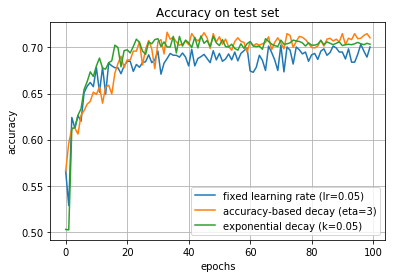

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.title('Accuracy on test set')
plt.plot(history1.epoch,history1.history['val_acc'],label='fixed learning rate (lr=0.05)')
plt.plot(history1.epoch,history2.history['val_acc'],label='accuracy-based decay (eta=3)')
plt.plot(history1.epoch,history3.history['val_acc'],label='exponential decay (k=0.05)')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)

#### We can see that the consistent small gain in accuracy can be observed after the 20th epoch for decaying learning rates. We note that a more reliable comparison would report the averages over several runs of the same algorithm with different random seeds.

#### Finally, we visualize our learning rate schedules on the chart below.

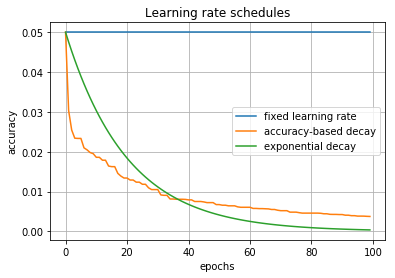

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.title('Learning rate schedules')
plt.plot(history1.epoch,[0.05]*epochs,label='fixed learning rate')
plt.plot(history1.epoch,lr_accuracy_based_decay,label='accuracy-based decay')
plt.plot(history1.epoch,lr_exponential_decay,label='exponential decay')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.grid(True)